Install Dependencies

In [1]:
!pip install --no-deps "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.29" "trl<0.9.0" peft accelerate bitsandbytes
!pip install unsloth_zoo

import torch
from unsloth import FastLanguageModel
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login

# Verify GPU availability
print(f"Using GPU: {torch.cuda.get_device_name(0)}")

# Secure Login
user_secrets = UserSecretsClient()
login(token=user_secrets.get_secret("HF_TOKEN"))

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-ejdh3sjz/unsloth_192fb6c3b418440384320fa425ef221f
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-ejdh3sjz/unsloth_192fb6c3b418440384320fa425ef221f
  Resolved https://github.com/unslothai/unsloth.git to commit 4cb7229ac1c346e143524b6f9a6ad544259364d6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unsloth: filename=unsloth-2026.1.4-py3-none-any.whl size=412535 sha256=de1cbdbb35b96a1f056673ae3250f2f1a5ac19842fbb2b5fc1de9c966e250a89
  Stored in directory: /tmp/pip-ephem-wheel-cache-soo0nr_w/wheels/60/3e/1f/e576c07051d90cf64b6a41434d87ccf4db33fafd5343bf5de0
Successfully built unsloth
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 21.3 MB/s eta 0:00:00
   ━━━━━━

2026-01-26 05:33:44.470369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769405624.670394      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769405624.727612      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769405625.194584      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769405625.194624      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769405625.194627      24 computation_placer.cc:177] computation placer alr

🦥 Unsloth Zoo will now patch everything to make training faster!
Using GPU: Tesla T4


Model and Tokenizer Loading

In [2]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",
    max_seq_length = 2048,
    load_in_4bit = True,
)

# LoRA Adapters 
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, 
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, 
    bias = "none",    
    use_gradient_checkpointing = "unsloth",
)

print("✅ Model loaded and LoRA adapters added!")

==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Unsloth 2026.1.4 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


✅ Model loaded and LoRA adapters added!


Loading dataset (financial phrasebank)

In [3]:
from datasets import load_dataset

dataset = load_dataset("FinanceMTEB/financial_phrasebank", split="train")

label_map = {0: "negative", 1: "neutral", 2: "positive"}

def formatting_prompts_func(examples):
    instructions = "Classify the financial sentiment of the headline as positive, negative, or neutral."
    inputs       = examples["text"] 
    outputs      = [label_map[l] for l in examples["label"]]
    
    texts = []
    for input_text, output_text in zip(inputs, outputs):
        text = f"### Instruction:\n{instructions}\n\n### Input:\n{input_text}\n\n### Response:\n{output_text}"
        texts.append(text)
    return { "text" : texts }

dataset = dataset.map(formatting_prompts_func, batched = True)

print(f"✅ Success! Dataset loaded and formatted for Llama-3.2.")
print(f"Sample: {dataset[0]['text']}")

README.md:   0%|          | 0.00/465 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/104k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/80.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1264 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1264 [00:00<?, ? examples/s]

✅ Success! Dataset loaded and formatted for Llama-3.2.
Sample: ### Instruction:
Classify the financial sentiment of the headline as positive, negative, or neutral.

### Input:
The Samsung Mobile Applications Store was launched in January 2009 by Samsung Mobile Innovator , a program which enables mobile software developers to create applications for use across Samsung mobile devices .

### Response:
neutral


Training

used Gradient Accumulation to simulate a larger batch size on limited hardware and implemented 8-bit AdamW with FP16 precision to maximize VRAM efficiency on a single-node GPU

In [4]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = 2048,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60, 
        learning_rate = 2e-4,
        fp16 = True,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        output_dir = "outputs",
        report_to = "none",
        average_tokens_across_devices = False,
    ),
)

trainer.train()

Unsloth: Tokenizing ["text"] (num_proc=8):   0%|          | 0/1264 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,264 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 24,313,856 of 3,237,063,680 (0.75% trained)


Step,Training Loss
1,3.653100
2,3.576000
3,3.323400
4,3.454000
5,3.273300
6,2.888100
7,2.638000
8,2.334400
9,2.071000
10,1.817300


TrainOutput(global_step=60, training_loss=1.806685209274292, metrics={'train_runtime': 106.1458, 'train_samples_per_second': 9.044, 'train_steps_per_second': 0.565, 'total_flos': 1163926530441216.0, 'train_loss': 1.806685209274292, 'epoch': 0.759493670886076})

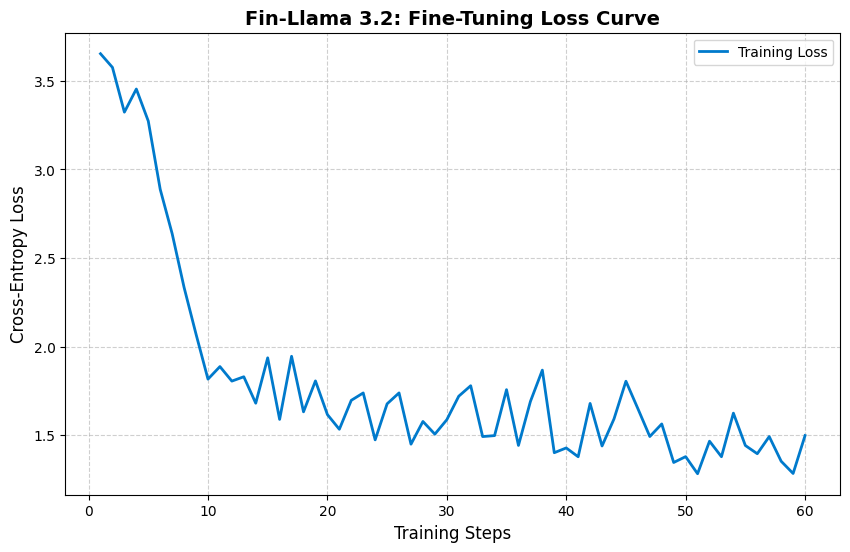

In [5]:
import matplotlib.pyplot as plt

history = trainer.state.log_history

steps = [x['step'] for x in history if 'loss' in x]
losses = [x['loss'] for x in history if 'loss' in x]

plt.figure(figsize=(10, 6))
plt.plot(steps, losses, label='Training Loss', color='#007acc', linewidth=2)
plt.title('Fin-Llama 3.2: Fine-Tuning Loss Curve', fontsize=14, fontweight='bold')
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Cross-Entropy Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

Inference

In [6]:
from unsloth import FastLanguageModel

FastLanguageModel.for_inference(model) 
headline = "Standard Chartered raises India's GDP growth forecast to 7.2% for FY25."
prompt = f"### Instruction:\nClassify the financial sentiment of the headline as positive, negative, or neutral.\n\n### Input:\n{headline}\n\n### Response:\n"
inputs = tokenizer([prompt], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 20)
result = tokenizer.batch_decode(outputs)[0]

prediction = result.split("### Response:\n")[-1].strip()
print(f"Headline: {headline}")
print(f"Predicted Sentiment: {prediction}")

Headline: Standard Chartered raises India's GDP growth forecast to 7.2% for FY25.
Predicted Sentiment: positive

### Context:
Standard Chartered Bank has raised India's GDP growth forecast to 7


model tracking using wandb

In [7]:
import os
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("WANDB_API_KEY")

os.environ["WANDB_API_KEY"] = wandb_key

wandb.login()

run = wandb.init(
    entity="kaggle_llama_project",
    project="kaggle-_llama_project",
    name="kaggle-prototype-run-1",
    job_type="training"
)

wandb: Currently logged in as: ayushpallod07 (kaggle_llama_project) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20260126_053644-fkur8z2s
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run kaggle-prototype-run-1
wandb: ⭐️ View project at https://wandb.ai/kaggle_llama_project/kaggle-_llama_project
wandb: 🚀 View run at https://wandb.ai/kaggle_llama_project/kaggle-_llama_project/runs/fkur8z2s
wandb: Detected [huggingface_hub.inference, openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


In [8]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = 2048,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60, 
        learning_rate = 2e-4,
        fp16 = True,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        output_dir = "outputs",

        report_to = "wandb",
        run_name = "kaggle_llama-v1",
        average_tokens_across_devices = False, 
    ),
)

trainer.train()
wandb.finish()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,264 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 24,313,856 of 3,237,063,680 (0.75% trained)


Step,Training Loss
1,1.403500
2,1.426700
3,1.365200
4,1.477300
5,1.455700
6,1.383900
7,1.351700
8,1.459400
9,1.350900
10,1.295100


wandb: updating run metadata
wandb: 
wandb: Run history:
wandb:         train/epoch ▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
wandb:   train/global_step ▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
wandb:     train/grad_norm █▇▅▅▄▁▂▁▁▁▂▁▁▂▂▁▂▃▂▂▃▂▃▃▃▂▂▂▂▃▃▂▂▂▃▂▂▄▂▃
wandb: train/learning_rate ▁▄▅▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁
wandb:          train/loss ▄▄▄▅▅▃▅▂▅▄▂▆▂▃▃▃▄▄▅▁▂▃▄▂▂▆█▂▂▂▇▆▃▄▂▂▆▂▄▁
wandb: 
wandb: Run summary:
wandb:               total_flos 1163926530441216.0
wandb:              train/epoch 0.75949
wandb:        train/global_step 60
wandb:          train/grad_norm 0.8584
wandb:      train/learning_rate 0.0
wandb:               train/loss 1.3784
wandb:               train_loss 1.36183
wandb:            train_runtime 101.7462
wandb: train_samples_per_second 9.435
wandb:   train_steps_per_second 0.59
wandb: 
wandb: 🚀 View run kaggle-prototype-run-1 at: https://wandb.ai/kaggle_llama_project/kaggle-_llama_project/runs/fkur8z2s
wandb: ⭐️ View project at: https://wandb.ai/kaggle_l

In [9]:
# Save the LoRA adapters to a folder named 'fin_llama_adapters'
model.save_pretrained("fin_llama_adapters")
tokenizer.save_pretrained("fin_llama_adapters")
print("✅ Weights saved to /kaggle/working/fin_llama_adapters")

✅ Weights saved to /kaggle/working/fin_llama_adapters


In [10]:
import os

# 1. Move into your repository folder
%cd /kaggle/working/llama_finetune_e2e_finance

# 2. Copy the Notebook file into the repo
# Kaggle keeps the current running notebook at /kaggle/working/__notebook__.ipynb
!cp /kaggle/working/__notebook__.ipynb ./fin_llama_sentiment_v1.ipynb

# 3. Copy the weights folder we just created into the repo
!cp -r /kaggle/working/fin_llama_adapters ./fin_llama_adapters

# 4. Tell Git LFS to track the weight files (to avoid the 100MB limit)
!git lfs track "fin_llama_adapters/*.safetensors"
!git lfs track "fin_llama_adapters/*.bin"
!git add .gitattributes

# 5. Add, Commit, and Push
!git add fin_llama_sentiment_v1.ipynb fin_llama_adapters/
!git commit -m "Phase 2 Complete: Saved Notebook and LoRA Weights"
!git push origin main

[Errno 2] No such file or directory: '/kaggle/working/llama_finetune_e2e_finance'
/kaggle/working
cp: cannot copy a directory, '/kaggle/working/fin_llama_adapters', into itself, './fin_llama_adapters/fin_llama_adapters'
Not in a git repository.
Not in a git repository.
fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
